In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from folium.plugins import HeatMap

In [2]:
df_airbnb = pd.read_csv('airbnb_cat.csv', index_col='id', engine='python', sep =',', encoding="utf-8")
df_airbnb.head()

,host_name,host_response_time,host_response_rate,host_is_superhost,host_identity_verified,neighbourhood,zipcode,latitude,longitude,property_type,...,Wide_entrance_for_guests,Wide_entryway,Wide_hallways,Wifi,Window_guards,Wine_cooler,_toilet,translation_missing:_en.hosting_amenity_49,translation_missing:_en.hosting_amenity_50,m2
id,,,,,,,,,,,,,,,,,,,,,
17878,Matthias,within an hour,1.00,t,t,Copacabana,22020-050,-22.96592,-43.17896,Condominium,...,0,0,0,1,0,0,0,0,0,12169.0
25026,Viviane,within a day,0.91,f,t,Copacabana,22060-020,-22.97712,-43.19045,Apartment,...,0,0,0,1,0,0,0,0,0,12169.0
31560,Renata,within an hour,1.00,t,t,Ipanema,22410-003,-22.98302,-43.21427,Apartment,...,0,0,0,1,0,0,0,1,1,20908.0
35636,Patricia,within an hour,1.00,t,t,Ipanema,22081-020,-22.98816,-43.19359,Apartment,...,0,0,0,1,0,0,0,0,0,20908.0
35764,Patricia Miranda & Paulo,within an hour,1.00,t,t,Copacabana,21031-300,-22.98127,-43.19046,Loft,...,1,1,0,1,0,0,0,0,1,12169.0


In [3]:
# Lista de atributos com maior correlação direta ou inversa com o preço

corr = df_airbnb.corr()
corr['abs_price'] = abs(corr['price'])
corr.sort_values(by = ['abs_price'], ascending = False, inplace = True)
corr['price'][1:51]

bathrooms                         0.346099
bedrooms                          0.340403
cleaning_fee                      0.297867
accommodates                      0.289593
security_deposit                  0.232237
beds                              0.230465
guests_included                   0.206380
Free_parking_on_premises          0.156258
extra_people                      0.142784
Pool                              0.139611
Dryer                             0.129335
latitude                         -0.105419
m2                                0.104599
reviews_per_month                -0.101669
Hot_tub                           0.099603
Washer                            0.096270
Air_conditioning                  0.095262
Dishwasher                        0.089541
Crib                              0.087597
Suitable_for_events               0.082411
Family/kid_friendly               0.080306
Internet                          0.078954
Full_kitchen                      0.076998
calculated_

Text(0.5, 0, 'Correlação')

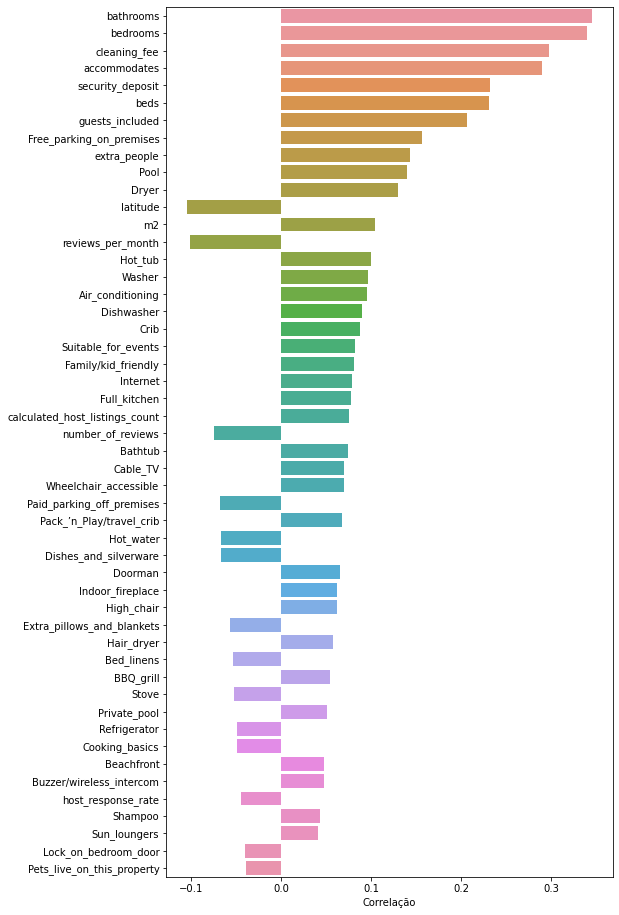

In [4]:
# Visualização de atributos com maior correlação direta ou inversa com o preço

corr = corr['price'][1:51]
plt.figure(figsize=(8, 16))
ax = sns.barplot(corr.values, corr.index)
ax.set_xlabel('Correlação')

In [5]:
# Seleção dos vinte atributos mais relevantes à modelagem preditiva (feature selection).

# Atributos redundantes não serão selecionados para não confundir o modelo.
# A seleção será feita com base na força da correlação e na unicidade da característica descrita
# Por exemplo: Bathrooms, bedrooms, accomodates e beds referem-se à mesma característica: Capacidade de acomodação do imóvel
# Portanto, desses atributos, apenas um será selecionado.
# De acordo com o conhecimento do negócio, para essa característica, será Bedrooms.
# Pois o atributo de maior destaque em relação à acomodação, em anúncios de hospedagem, costuma ser a quantidade de quartos.

# Como o dataset possui 202 atributos e, pela descrição dos atributos mais relevantes, selecionamos os 10% melhores.

top_correlated = ['bedrooms', 'cleaning_fee', 'security_deposit', 'Free_parking_on_premises', 'extra_people', 'Pool', 'Dryer', 'm2', 'reviews_per_month', 'Hot_tub', 'Air_conditioning', 'Crib', 'Washer', 'Dishwasher', 'Suitable_for_events', 'property_type', 'Full_kitchen', 'Internet', 'Bathtub', 'Cable_TV']

In [6]:
# Seleção de atributos auxiliares e alvo

extra = ['latitude', 'longitude', 'neighbourhood', 'room_type']
target = ['price']

In [7]:
# elaboração da lista de features a serem analisadas

features = extra + top_correlated + target
features

['latitude',
 'longitude',
 'neighbourhood',
 'room_type',
 'bedrooms',
 'cleaning_fee',
 'security_deposit',
 'Free_parking_on_premises',
 'extra_people',
 'Pool',
 'Dryer',
 'm2',
 'reviews_per_month',
 'Hot_tub',
 'Air_conditioning',
 'Crib',
 'Washer',
 'Dishwasher',
 'Suitable_for_events',
 'property_type',
 'Full_kitchen',
 'Internet',
 'Bathtub',
 'Cable_TV',
 'price']

In [8]:
df_airbnb = df_airbnb[features]
df_airbnb

,latitude,longitude,neighbourhood,room_type,bedrooms,cleaning_fee,security_deposit,Free_parking_on_premises,extra_people,Pool,...,Crib,Washer,Dishwasher,Suitable_for_events,property_type,Full_kitchen,Internet,Bathtub,Cable_TV,price
id,,,,,,,,,,,,,,,,,,,,,
17878,-22.96592,-43.17896,Copacabana,Entire home/apt,2.0,378.0,0.0,0,63.0,0,...,0,0,0,1,Condominium,0,1,0,1,332.0
25026,-22.97712,-43.19045,Copacabana,Entire home/apt,1.0,250.0,1000.0,0,45.0,0,...,0,0,0,0,Apartment,0,1,0,1,160.0
31560,-22.98302,-43.21427,Ipanema,Entire home/apt,1.0,84.0,0.0,0,42.0,0,...,0,0,0,0,Apartment,0,1,0,1,273.0
35636,-22.98816,-43.19359,Ipanema,Entire home/apt,1.0,172.0,1050.0,0,63.0,0,...,0,1,0,0,Apartment,0,1,0,1,378.0
35764,-22.98127,-43.19046,Copacabana,Entire home/apt,1.0,140.0,400.0,0,80.0,0,...,0,0,0,0,Loft,0,0,0,1,130.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40009653,-22.98304,-43.19569,Copacabana,Entire home/apt,2.0,150.0,0.0,0,100.0,0,...,0,1,0,0,Apartment,0,0,0,0,449.0
40025707,-22.97132,-43.18929,Copacabana,Entire home/apt,1.0,140.0,500.0,0,25.0,0,...,0,0,0,0,Apartment,0,0,0,0,101.0
40033232,-22.91599,-43.17894,Santa Teresa,Entire home/apt,0.0,120.0,0.0,0,50.0,0,...,0,0,0,0,Apartment,0,0,0,0,109.0


In [9]:
# Mapa de calor - Concentração de anúncios por bairros

m=folium.Map([-22.92538,-43.29582],zoom_start=12)
HeatMap(df_airbnb[['latitude','longitude']],radius=8,gradient={0.25:'blue',0.5:'purple',0.75:'orange',1.0:'red'}).add_to(m)
display(m)

Text(0.5, 0, 'Média de preço por bairro')

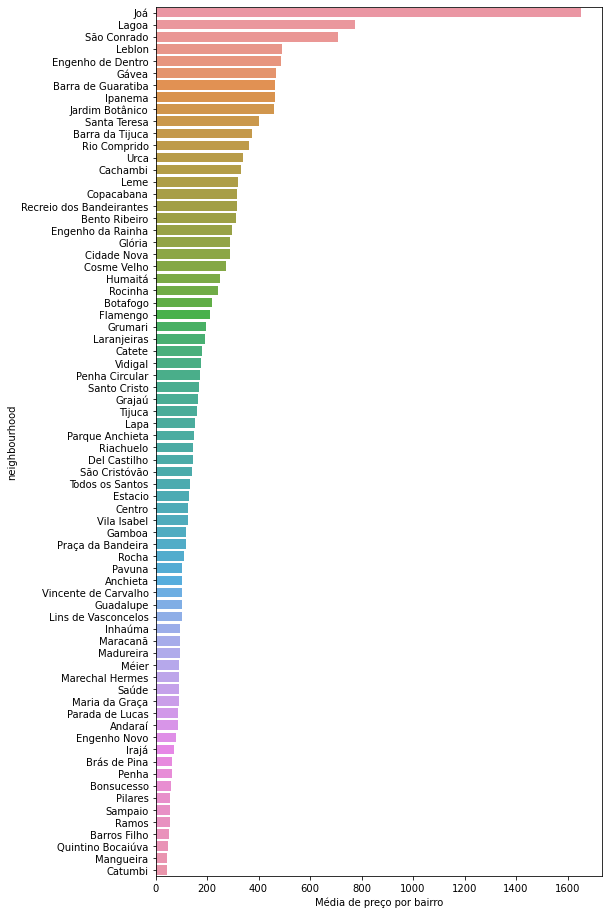

In [10]:
# Exibindo a média de preços dos anúncios por bairro

df_plot = pd.DataFrame(data=df_airbnb.groupby("neighbourhood")["price"].mean())
df_plot.sort_values(by="price", ascending=False, inplace=True)
df_plot.reset_index(inplace=True)
plt.figure(figsize=(8, 16))
ax = sns.barplot(y='neighbourhood', x='price', data=df_plot)
ax.set_xlabel('Média de preço por bairro')

Text(0.5, 0, 'Contagem de anúncios por bairro')

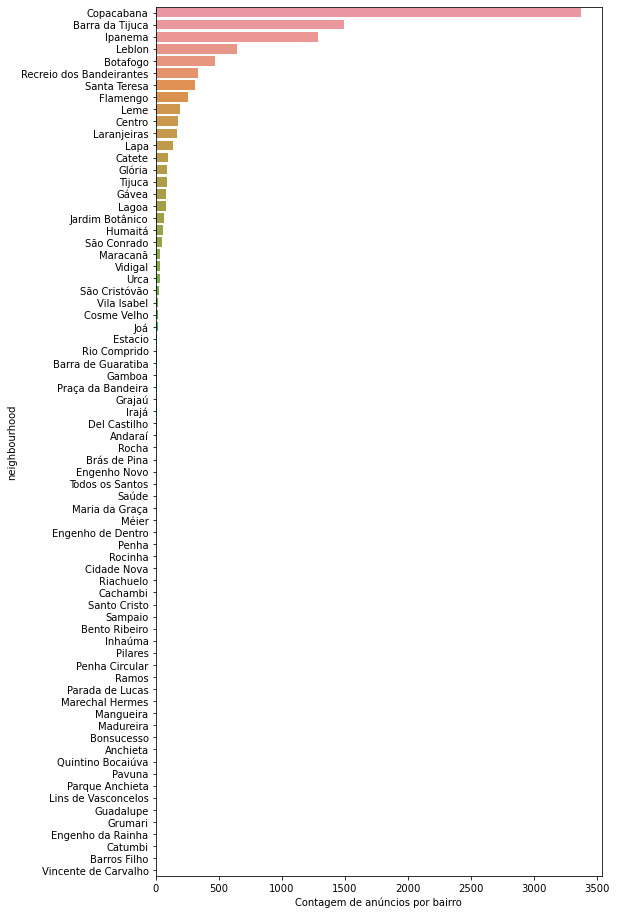

In [11]:
# Exibindo a contagem de anúncios por bairro

df_plot = pd.DataFrame(data=df_airbnb.groupby("neighbourhood")["price"].count())
df_plot.sort_values(by="price", ascending=False, inplace=True)
df_plot.reset_index(inplace=True)
plt.figure(figsize=(8, 16))
ax = sns.barplot(y='neighbourhood', x='price', data=df_plot)
ax.set_xlabel('Contagem de anúncios por bairro')

In [12]:
# O bairro do Joá produziu uma distorção nas estatísticas, pois possui poucos anúncios, porém com uma média de valores bastante alta.
# Além disso, observamos uma grande quantidade de bairros com poucos anúncios, o que poderia causar distorções semelhantes.
# Outros exemplos: Barra de Guaratiba, Rio Comprido e Bento Ribeiro.
# Pelo conhecimento do negócio, é sabido que essas regiões não possuem um valor condizente com suas respectivas médias.
# Portanto, decidiremos por analisar apenas 25% dos bairros com a maior quantidade de anúncios, para evitar esse tipo de distorção.

bairros_validos = df_plot['neighbourhood'].head(int(len(df_plot)*(0.25))).to_list()
bairros_validos

['Copacabana',
 'Barra da Tijuca',
 'Ipanema',
 'Leblon',
 'Botafogo',
 'Recreio dos Bandeirantes',
 'Santa Teresa',
 'Flamengo',
 'Leme',
 'Centro',
 'Laranjeiras',
 'Lapa',
 'Catete',
 'Glória',
 'Tijuca',
 'Gávea',
 'Lagoa',
 'Jardim Botânico']

In [13]:
# Aplicando o filtro no dataframe

df_airbnb = df_airbnb[df_airbnb['neighbourhood'].isin(bairros_validos)]
df_airbnb.shape

(9364, 25)

In [14]:
df_airbnb.describe()

,latitude,longitude,bedrooms,cleaning_fee,security_deposit,Free_parking_on_premises,extra_people,Pool,Dryer,m2,...,Air_conditioning,Crib,Washer,Dishwasher,Suitable_for_events,Full_kitchen,Internet,Bathtub,Cable_TV,price
count,9364.000000,9364.000000,9364.000000,9364.000000,9364.000000,9364.000000,9364.000000,9364.000000,9364.000000,9364.000000,...,9364.000000,9364.000000,9364.000000,9364.000000,9364.000000,9364.000000,9364.000000,9364.000000,9364.000000,9364.000000
mean,-22.972215,-43.229913,1.570589,148.193614,659.759398,0.320162,53.038659,0.241670,0.184003,12967.181760,...,0.870034,0.025737,0.637441,0.042183,0.051153,0.006194,0.343550,0.021892,0.532678,348.061726
std,0.025245,0.080950,0.993213,101.203902,1360.006355,0.466564,85.635426,0.428118,0.387507,4943.996298,...,0.336284,0.158358,0.480765,0.201017,0.220322,0.078462,0.474918,0.146340,0.498958,669.020077
min,-23.032630,-43.523750,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3277.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,-22.984630,-43.222552,1.000000,100.000000,0.000000,0.000000,0.000000,0.000000,0.000000,9334.000000,...,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,143.000000
50%,-22.976015,-43.192110,1.000000,150.000000,400.000000,0.000000,39.000000,0.000000,0.000000,12169.000000,...,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,218.000000
75%,-22.963830,-43.184595,2.000000,195.000000,800.000000,1.000000,70.000000,0.000000,0.000000,12211.000000,...,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,369.000000
max,-22.896090,-43.164160,15.000000,1469.000000,20991.000000,1.000000,1259.000000,1.000000,1.000000,23625.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,31398.000000


Text(0.5, 0, 'Média de preço por bairro')

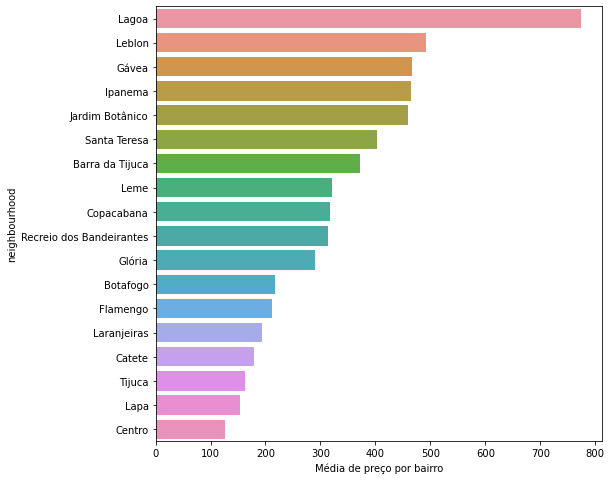

In [15]:
# Exibindo a média de preços dos anúncios por bairro - apenas com os bairros com mais anúncios

df_plot = pd.DataFrame(data=df_airbnb.groupby("neighbourhood")["price"].mean())
df_plot.sort_values(by="price", ascending=False, inplace=True)
df_plot.reset_index(inplace=True)
df_plot = df_plot[df_plot['neighbourhood'].isin(bairros_validos)]
plt.figure(figsize=(8, 8))
ax = sns.barplot(y='neighbourhood', x='price', data=df_plot)
ax.set_xlabel('Média de preço por bairro')

Text(0.5, 0, 'Contagem de anúncios por bairro')

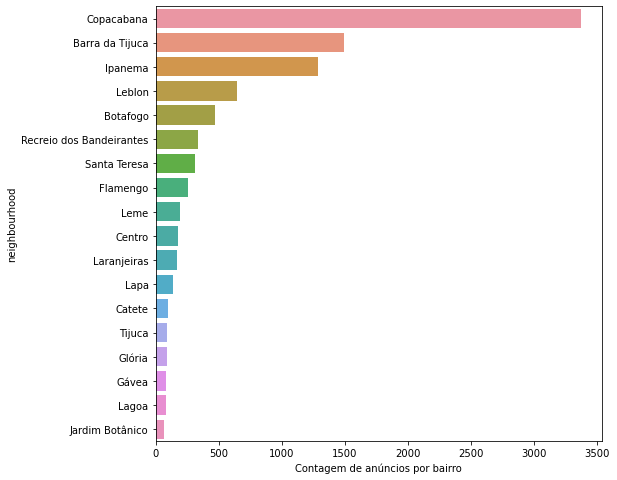

In [16]:
# Exibindo a contagem de anúncios por bairro - apenas com os bairros com mais anúncios

df_plot = pd.DataFrame(data=df_airbnb.groupby("neighbourhood")["price"].count())
df_plot.sort_values(by="price", ascending=False, inplace=True)
df_plot.reset_index(inplace=True)
df_plot = df_plot[df_plot['neighbourhood'].isin(bairros_validos)]
plt.figure(figsize=(8, 8))
ax = sns.barplot(y='neighbourhood', x='price', data=df_plot)
ax.set_xlabel('Contagem de anúncios por bairro')

In [17]:
df_properties_statistics = pd.DataFrame(data=df_airbnb.groupby("property_type")["price"].count())
df_properties_statistics.rename(columns={"price":"quantidade"}, inplace=True)
df_properties_statistics.sort_values(by="quantidade", ascending=False, inplace=True)
df_properties_statistics

,quantidade
property_type,
Apartment,7423
Condominium,658
House,379
Serviced apartment,348
Loft,253
Guest suite,55
Guesthouse,46
Aparthotel,42
Bed and breakfast,33


Text(0.5, 0, 'Contagem de anúncios por tipos de propriedades - com filtro')

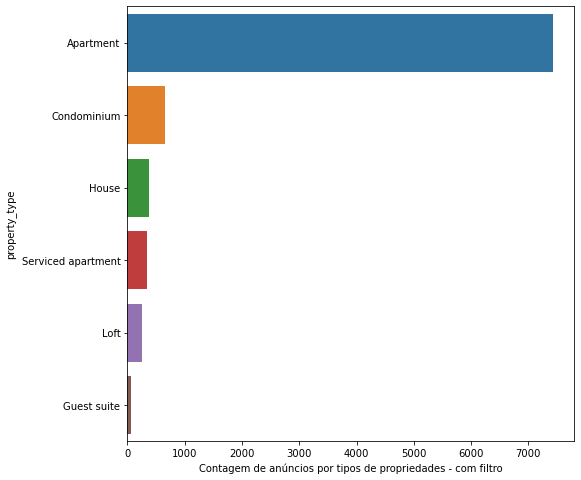

In [18]:
tipos_de_propriedades_validas = df_properties_statistics.head(int(len(df_properties_statistics)*(0.25)))
plt.figure(figsize=(8, 8))
ax = sns.barplot(tipos_de_propriedades_validas.quantidade, tipos_de_propriedades_validas.index)
ax.set_xlabel('Contagem de anúncios por tipos de propriedades - com filtro')

In [19]:
# Aplicando o filtro de tipos de propriedades no dataframe

df_airbnb = df_airbnb[df_airbnb['property_type'].isin(tipos_de_propriedades_validas.index.to_list())]
df_airbnb.shape

(9116, 25)

Text(0.5, 0, 'Contagem de anúncios por tipos de acomodação')

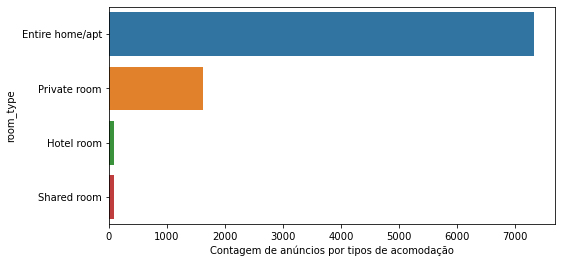

In [20]:
df_plot = pd.DataFrame(data=df_airbnb.groupby("room_type")["price"].count())
df_plot.rename(columns={"price":"quantidade"}, inplace=True)
df_plot.sort_values(by="quantidade", ascending=False, inplace=True)
plt.figure(figsize=(8, 4))
ax = sns.barplot(df_plot.quantidade, df_plot.index)
ax.set_xlabel('Contagem de anúncios por tipos de acomodação')

In [21]:
df_plot

,quantidade
room_type,
Entire home/apt,7326
Private room,1615
Hotel room,91
Shared room,84


Text(0.5, 0, 'Contagem de anúncios por quantidade de dormitórios')

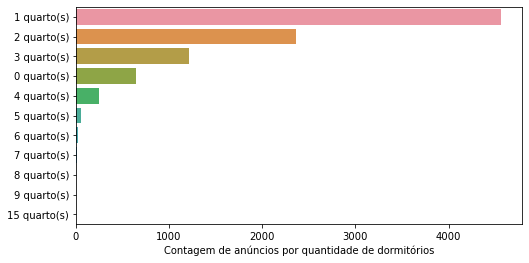

In [22]:
df_plot = pd.DataFrame(data=df_airbnb.groupby("bedrooms")["price"].count())
df_plot.rename(columns={"price":"quantidade"}, inplace=True)
df_plot.sort_values(by="quantidade", ascending=False, inplace=True)
#df_plot.reset_index(inplace=True)
#df_plot.index.astype(str).tolist()
plt.figure(figsize=(8, 4))
ax = sns.barplot(df_plot['quantidade'], df_plot.index.astype('int32').astype(str) + " quarto(s)")
ax.set_xlabel('Contagem de anúncios por quantidade de dormitórios')

In [23]:
# Aplicando o filtro de quantidade de dormitórios no dataframe

print("Quantidade de registros no dataframe antes da aplicação do filtro: " + str(df_airbnb.shape[0]))
qt_dormitorios = df_plot.head(int(len(df_plot)*(0.5))).index.to_list()
df_airbnb = df_airbnb[df_airbnb['bedrooms'].isin(qt_dormitorios)]
print("Quantidade de registros no dataframe depois da aplicação do filtro: " + str(df_airbnb.shape[0]))

Quantidade de registros no dataframe antes da aplicação do filtro: 9116
Quantidade de registros no dataframe depois da aplicação do filtro: 9032


Text(0.5, 0, 'Contagem de anúncios por quantidade de dormitórios - com filtro')

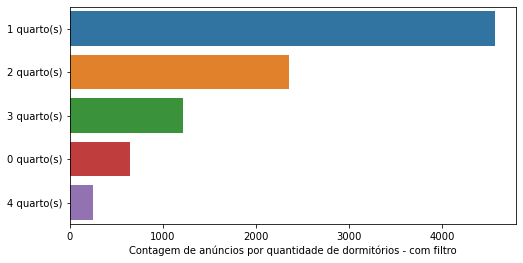

In [24]:
df_plot = pd.DataFrame(data=df_airbnb.groupby("bedrooms")["price"].count())
df_plot.rename(columns={"price":"quantidade"}, inplace=True)
df_plot.sort_values(by="quantidade", ascending=False, inplace=True)
plt.figure(figsize=(8, 4))
ax = sns.barplot(df_plot['quantidade'], df_plot.index.astype('int32').astype(str) + " quarto(s)")
ax.set_xlabel('Contagem de anúncios por quantidade de dormitórios - com filtro')

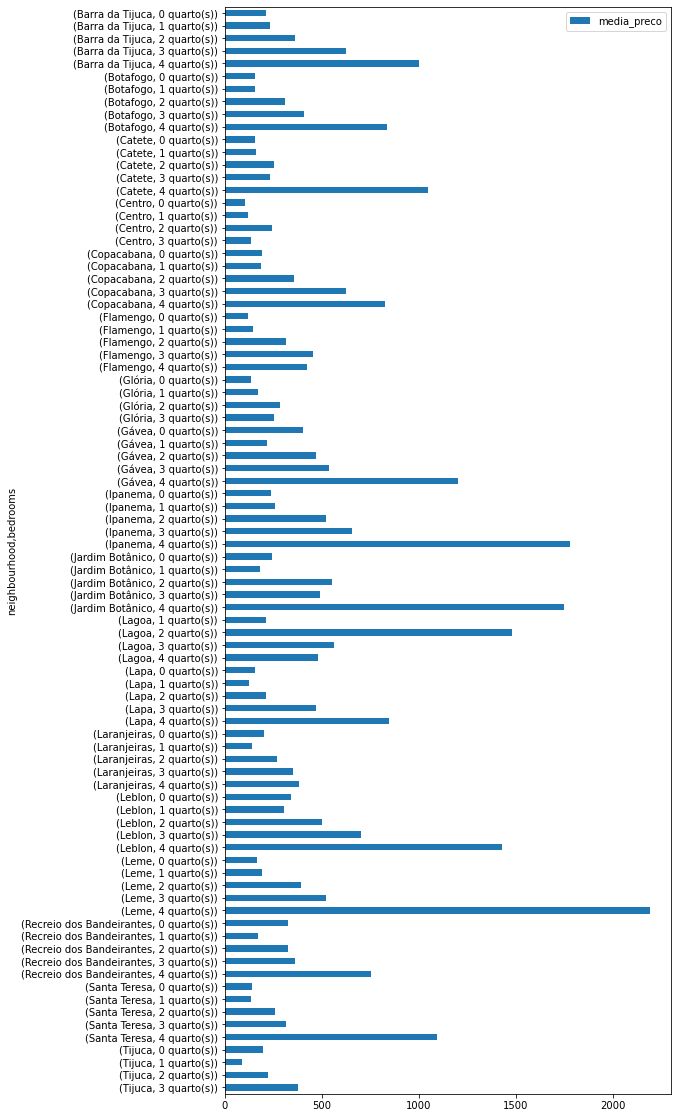

In [25]:
# Média de preço por quartos por bairro

df_plot = pd.DataFrame(df_airbnb.groupby(['neighbourhood', 'bedrooms'])['price'].mean())
df_plot.rename(columns={"price":"media_preco"}, inplace=True)
df_plot.sort_index(inplace=True, ascending=False)
df_plot.reset_index(inplace=True)
df_plot['bedrooms'] = df_plot['bedrooms'].astype('int32').astype(str) + ' quarto(s)'
df_plot.set_index(['neighbourhood', 'bedrooms'], inplace=True)
#plt.figure(figsize=(12, 12))
#df_plot.plot.scatter(y='neighbourhood', x='bedrooms', c='media_preco', colormap='plasma', figsize=(12, 8))
df_plot.plot.barh(figsize=(8, 20))

In [26]:
# Converte os atributos categóricos em quantitativos discretos.

for column in df_airbnb.columns:
    if str(df_airbnb[column].dtype) not in ['float64', 'int64']:
        df_airbnb[column] = df_airbnb[column].map \
        (dict(zip(df_airbnb[column].unique().tolist(),range(len(df_airbnb[column].unique().tolist())))))
df_airbnb

,latitude,longitude,neighbourhood,room_type,bedrooms,cleaning_fee,security_deposit,Free_parking_on_premises,extra_people,Pool,...,Crib,Washer,Dishwasher,Suitable_for_events,property_type,Full_kitchen,Internet,Bathtub,Cable_TV,price
id,,,,,,,,,,,,,,,,,,,,,
17878,-22.96592,-43.17896,0,0,2.0,378.0,0.0,0,63.0,0,...,0,0,0,1,0,0,1,0,1,332.0
25026,-22.97712,-43.19045,0,0,1.0,250.0,1000.0,0,45.0,0,...,0,0,0,0,1,0,1,0,1,160.0
31560,-22.98302,-43.21427,1,0,1.0,84.0,0.0,0,42.0,0,...,0,0,0,0,1,0,1,0,1,273.0
35636,-22.98816,-43.19359,1,0,1.0,172.0,1050.0,0,63.0,0,...,0,1,0,0,1,0,1,0,1,378.0
35764,-22.98127,-43.19046,0,0,1.0,140.0,400.0,0,80.0,0,...,0,0,0,0,2,0,0,0,1,130.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40009653,-22.98304,-43.19569,0,0,2.0,150.0,0.0,0,100.0,0,...,0,1,0,0,1,0,0,0,0,449.0
40025707,-22.97132,-43.18929,0,0,1.0,140.0,500.0,0,25.0,0,...,0,0,0,0,1,0,0,0,0,101.0
40033232,-22.91599,-43.17894,5,0,0.0,120.0,0.0,0,50.0,0,...,0,0,0,0,1,0,0,0,0,109.0


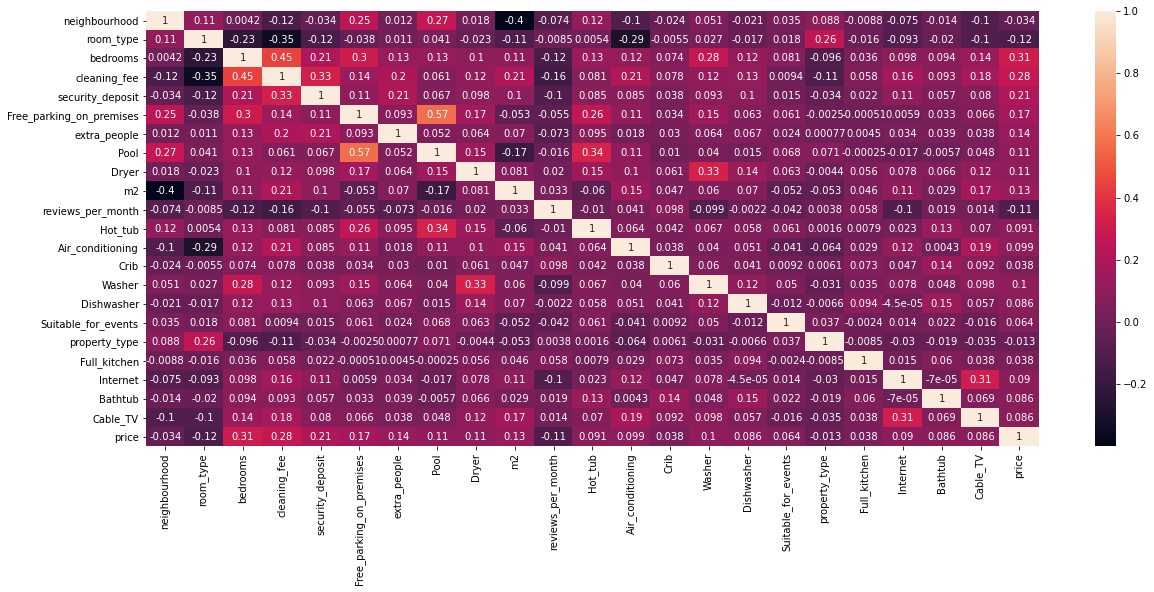

In [27]:
# Matriz de correlação

corr = df_airbnb.drop(columns=['latitude', 'longitude']).corr()
corr.style.background_gradient(cmap='coolwarm')
plt.figure(figsize=(20,8))
sns.heatmap(corr,annot=True)

In [28]:
df_airbnb = df_airbnb.head(9000)
print("Quantidade final de registros: "+ str(df_airbnb.shape[0]))

Quantidade final de registros: 9000


In [173]:
df_airbnb.to_csv('airbnb.csv')